In [1]:
# Importing the necessary libraries
import numpy as np
import matplotlib.pyplot as plt

import jax
import jax.numpy as jnp
import seaborn as sns
sns.set_style('whitegrid')

from tinygp import GaussianProcess, kernels
from stingray import Lightcurve

jax.config.update("jax_enable_x64", True)

/Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/stingray/utils.py:35: UserWarning: pyfftw not installed. Using standard scipy fft
  warnings.warn("pyfftw not installed. Using standard scipy fft")
/Users/gaurav/opt/anaconda3/envs/Stingproj/lib/python3.11/site-packages/stingray/utils.py:50: UserWarning: Numba not installed. Faking it
  warnings.warn("Numba not installed. Faking it")


In [3]:
from gpmodelling import get_kernel, get_mean
# suppress warnings
import warnings
warnings.filterwarnings("ignore")
times = np.linspace(0,1,256)

# We will take suitable parameters for a high amplitude QPO with a double skew gaussian mean
kernel_params  = {"arn" : jnp.exp(1.5),    "crn" : jnp.exp(1.0),
                  "aqpo": jnp.exp(-0.4),    "cqpo": jnp.exp(1),    "freq": 20,}
kernel = get_kernel(kernel_type = "QPO_plus_RN", kernel_params = kernel_params)

mean_params = {"A" : jnp.array([3.0, 4.0]), "t0" : jnp.array([0.2, 0.7]), 
               "sig1" : jnp.array([0.2, 0.1]), "sig2" : jnp.array([0.3, 0.4]),  }

mean = get_mean(mean_type = "skew_gaussian",  mean_params = mean_params)

jit = 5e-2
gp = GaussianProcess(kernel = kernel, X = times, mean_value = mean(times), diag = jit)

### Plotting the Sample Lightcurve

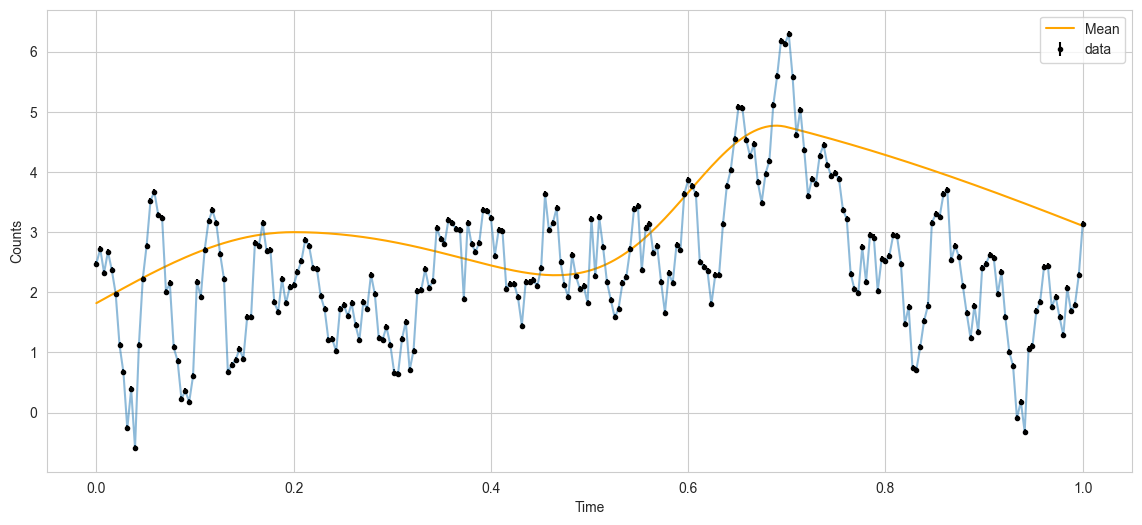

In [4]:
counts = gp.sample(key = jax.random.PRNGKey(6))
yerr = (jit)*np.ones_like(times)
fig, ax = plt.subplots(1,1, figsize = (14,6))
ax.errorbar(times, counts.T, yerr=yerr, fmt=".k", capsize=0, label="data")
ax.plot(times, mean(times), color = "orange" ,label = "Mean"); ax.legend()
ax.plot(times, counts, label = "Sample GP", alpha = 0.5)
ax.set_xlabel("Time"); ax.set_ylabel("Counts")

lc = Lightcurve(time = times, counts = counts, dt = times[1]- times[0], skip_checks = True)

In [6]:
array = np.array(counts)
toy_array = v=np.zeros((len(array), 2))
toy_array[:,0] = array
toy_array[:,1] = times
np.savetxt("toy_qpo_dataset.csv", toy_array, delimiter=',')
# np.savetxt("toy_qpo_dataset.csv", array, delimiter=',', header="counts", comments='')

In [7]:
import tensorflow_probability.substrates.jax as tfp
from gpmodelling import get_prior, get_likelihood, get_gp_params
tfpd = tfp.distributions
tfpb = tfp.bijectors

params_list = get_gp_params(kernel_type= "RN", mean_type = "gaussian")
print("parameters list", params_list)

parameters list ['arn', 'crn', 'A', 't0', 'sig']


In [8]:
total_time = times[-1] - times[0]
f = 1/(times[1]- times[0])
span = jnp.max(counts) - jnp.min(counts)

# The prior dictionary, with suitable tfpd prior distributions
prior_dict = {
    "A": tfpd.Uniform(low = 0.1 * span, high= 2 * span),
    "t0": tfpd.Uniform(low = times[0] - 0.1*total_time, high = times[-1] + 0.1*total_time),
    "sig": tfpd.Uniform(low = 0.5 * 1 / f, high = 2 * total_time),
    "arn": tfpd.Uniform(low = 0.1 * span, high = 2 * span),
    "crn": tfpd.Uniform(low = jnp.log(1 / total_time), high = jnp.log(f)),
}

prior_model = get_prior(params_list, prior_dict)

likelihood_model = get_likelihood(params_list, kernel_type= "RN", mean_type = "gaussian", Times = times, counts = counts)

# def likelihood_model(arn, crn, A, t0, sig):
#     kernel_params = { "arn": jnp.exp(arn), "crn": jnp.exp(crn), }
#     mean_params = {"A": jnp.exp(A), "t0": t0, "sig": jnp.exp(sig)}

#     kernel = get_kernel(kernel_type="RN", kernel_params=kernel_params)
#     mean = get_mean(mean_type="gaussian", mean_params=mean_params)
#     gp = GaussianProcess(kernel, Times, mean_value=mean(Times))

#     return gp.log_probability(counts)

In [9]:
from gpmodelling import GPResult

gpresult = GPResult(Lc = lc)
gpresult.sample(prior_model = prior_model, likelihood_model = likelihood_model)

INFO[2023-08-18 22:14:39,616]: Sanity check...
INFO[2023-08-18 22:14:39,835]: Sanity check passed


Simulation Complete


In [10]:
gpresult.print_summary()

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 151919
# samples: 5500
# slices: 45000.0
# slices / acceptance: 15.0
# likelihood evals / sample: 27.6
# likelihood evals / slice: 3.0
--------
logZ=-214.14 +- 0.074
H=210.0
ESS=1120
--------
A: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
A: 3.3 +- 1.7 | 1.3 / 3.1 / 5.4 | 2.9 | 2.9
--------
arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
arn: 9.5 +- 2.0 | 7.2 / 9.1 / 12.6 | 7.9 | 7.9
--------
crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
crn: 4.25 +- 0.81 | 3.15 / 4.33 / 5.3 | 4.87 | 4.87
--------
sig: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
sig: 1.09 +- 0.54 | 0.33 / 1.12 / 1.8 | 0.01 | 0.01
--------
t0: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
t0: 0.5 +- 0.35 | 0.02 / 0.52 / 0.99 | 0.7 | 0.7
--------


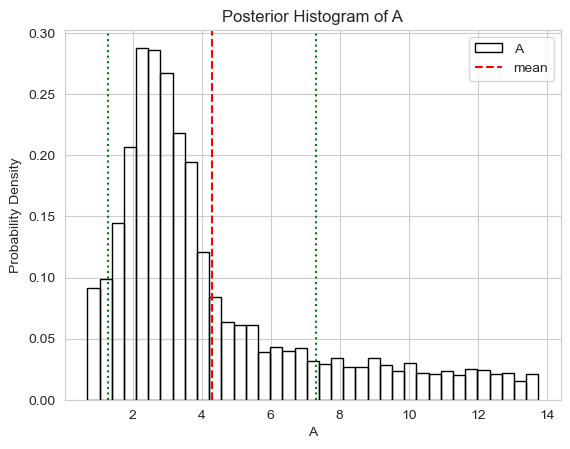

In [26]:
plot = gpresult.posterior_plot("A")
plt.show()

In [20]:
total_time = times[-1] - times[0]
f = 1/(times[1]- times[0])
span = jnp.max(counts) - jnp.min(counts)

# The prior dictionary, with suitable tfpd prior distributions
prior_dict2 = {
    "log_A": tfpd.Uniform(low = jnp.log(0.1 * span), high= jnp.log(2 * span)),
    "t0": tfpd.Uniform(low = times[0] - 0.1*total_time, high = times[-1] + 0.1*total_time),
    "log_sig": tfpd.Uniform(low = jnp.log(0.5 * 1 / f), high = jnp.log(2 * total_time)),
    "log_arn": tfpd.Uniform(low = jnp.log(0.1 * span), high = jnp.log(2 * span)),
    "log_crn": tfpd.Uniform(low = jnp.log(1 / total_time), high = jnp.log(f)),
}

params_list2 = ["log_arn", "log_crn", "log_A", "t0", "log_sig"]

prior_model2 = get_prior(params_list2, prior_dict2)

def likelihood_model2(log_arn, log_crn, log_A, t0, log_sig):
    kernel_params = { "arn": jnp.exp(log_arn), "crn": jnp.exp(log_crn), }
    mean_params = {"A": jnp.exp(log_A), "t0": t0, "sig": jnp.exp(log_sig)}

    kernel = get_kernel(kernel_type="RN", kernel_params=kernel_params)
    mean = get_mean(mean_type="gaussian", mean_params=mean_params)
    gp = GaussianProcess(kernel, times, mean_value=mean(times))

    return gp.log_probability(counts)

In [21]:
from gpmodelling import GPResult

gpresult2 = GPResult(Lc = lc)
gpresult2.sample(prior_model = prior_model2, likelihood_model = likelihood_model2)

INFO[2023-08-18 22:21:15,844]: Sanity check...
INFO[2023-08-18 22:21:15,849]: Sanity check passed


Simulation Complete


In [22]:
gpresult2.print_summary()

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 320152
# samples: 7500
# slices: 75000.0
# slices / acceptance: 15.0
# likelihood evals / sample: 42.7
# likelihood evals / slice: 4.0
--------
logZ=-212.16 +- 0.12
H=210.0
ESS=1539
--------
log_A: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_A: 0.98 +- 0.22 | 0.75 / 0.99 / 1.2 | 1.09 | 1.09
--------
log_arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_arn: 0.46 +- 0.46 | 0.01 / 0.37 / 1.01 | 0.01 | 0.01
--------
log_crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_crn: 3.26 +- 0.48 | 2.71 / 3.36 / 3.73 | 3.75 | 3.75
--------
log_sig: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_sig: -0.18 +- 0.71 | -0.83 / -0.09 / 0.51 | -0.78 | -0.78
--------
t0: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
t0: 0.65 +- 0.26 | 0.29 / 0.66 / 1.0 | 0.6 | 0.6
--------


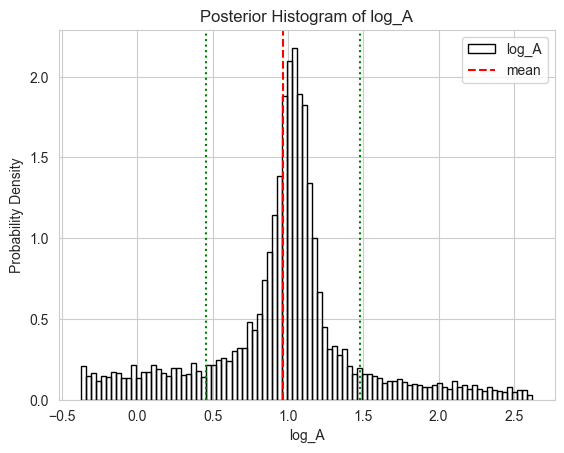

In [24]:
plot = gpresult2.posterior_plot("log_A")
plt.show()

# Model 2

In [27]:
# Prior Function
from jaxns import Prior
from jaxns.special_priors import ForcedIdentifiability
from jaxns.types import float_type

params_list3 = get_gp_params(kernel_type= "QPO_plus_RN", mean_type = "gaussian")
print(params_list3)

total_time = times[-1] - times[0]
f = 1/(times[1]- times[0])
span = jnp.max(counts) - jnp.min(counts)

# Here, we have made mutiple mean function with 2 gaussians.
def prior_model3():
    arn = yield Prior(tfpd.Uniform(low = 0.1 * span, high = 2 * span), name='arn')
    crn = yield Prior(tfpd.Uniform(low = jnp.log(1 / total_time), high = jnp.log(f)), name='crn')
    aqpo = yield Prior(tfpd.Uniform(low = 0.1 * span, high = 2 * span), name='aqpo')
    cqpo = yield Prior(tfpd.Uniform(low = 1/10/total_time, high = jnp.log(f)), name='cqpo')
    freq = yield Prior(tfpd.Uniform(low = 2 , high = f/4 ), name='freq')

    n = 2
    A = yield Prior(tfpd.Uniform(low = 0.1 * span*jnp.ones(n), high = 2 * span*jnp.ones(n)), name='A')
    
    # This is special conditional beta function for the peak times of gaussians which prevents degeneracies
    t0 = []
    scale_bij = tfp.bijectors.Scale(scale = times[-1] - times[0])
    shift_bij = tfp.bijectors.Shift(shift= times[0])
    for i in range(n):
        underlying_beta = tfpd.Beta(
            concentration1=jnp.asarray(1., float_type),
            concentration0=jnp.asarray(n - i, float_type)
        )
        t = yield Prior(shift_bij(scale_bij(underlying_beta)), name=f"t{i}")
        # Updating the shift and scale here
        scale_bij = tfp.bijectors.Scale(scale= times[-1] - t)
        shift_bij = tfp.bijectors.Shift(shift=t)
        t0.append(t)
    t0 = jnp.stack(t0)
    
    sig = yield Prior(tfpd.Uniform(low = 0.5 * 1 / f *jnp.ones(n), high = 2 * total_time *jnp.ones(n)), name='sig')

    return arn, crn, aqpo, cqpo, freq, A, t0, sig

['arn', 'crn', 'aqpo', 'cqpo', 'freq', 'A', 't0', 'sig']


In [28]:
def likelihood_model3(arn, crn, aqpo, cqpo, freq, A, t0, sig):
    
    kernel_params = { "arn": arn, "crn": crn, "aqpo": aqpo, "cqpo": cqpo, "freq": freq}
    mean_params = {"A": A, "t0": t0, "sig": sig}

    kernel = get_kernel(kernel_type="QPO_plus_RN", kernel_params=kernel_params)
    mean = get_mean(mean_type="gaussian", mean_params=mean_params)
    gp = GaussianProcess(kernel, times, mean_value=mean(times))

    return gp.log_probability(counts)

In [29]:
gpresult3 = GPResult(Lc = lc)
gpresult3.sample(prior_model = prior_model3, likelihood_model = likelihood_model3)

INFO[2023-08-18 22:23:21,396]: Sanity check...
INFO[2023-08-18 22:23:21,585]: Sanity check passed


Simulation Complete


In [30]:
gpresult3.print_summary()

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 649929
# samples: 9500
# slices: 247500.0
# slices / acceptance: 33.0
# likelihood evals / sample: 68.4
# likelihood evals / slice: 2.6
--------
logZ=-203.75 +- 0.14
H=200.0
ESS=1765
--------
A[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
A[0]: 2.3 +- 1.3 | 0.9 / 2.0 / 4.2 | 1.1 | 1.1
A[1]: 2.6 +- 1.6 | 1.0 / 2.2 / 4.6 | 1.5 | 1.5
--------
aqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
aqpo: 1.8 +- 1.5 | 0.8 / 1.2 / 3.5 | 0.9 | 0.9
--------
arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
arn: 8.6 +- 2.4 | 5.7 / 8.4 / 12.3 | 5.1 | 5.1
--------
cqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
cqpo: 1.14 +- 0.94 | 0.25 / 0.85 / 2.36 | 1.05 | 1.05
--------
crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
crn: 3.62 +- 0.99 | 2.35 / 3.5 / 5.09 | 5.35 | 5.35
--------
freq: mea

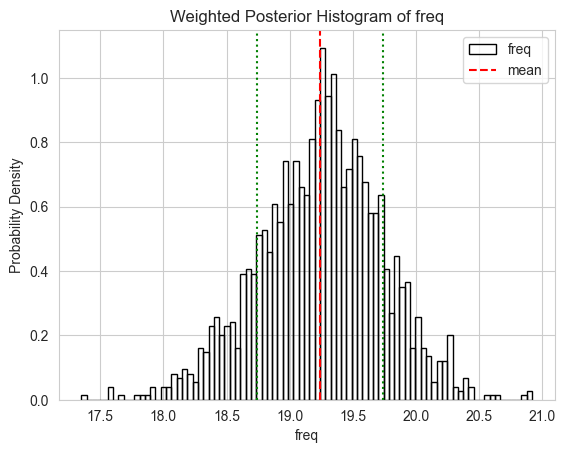

In [32]:
plot = gpresult3.weighted_posterior_plot("freq")

In [1]:
# Prior Function
from jaxns import Prior
from jaxns.special_priors import ForcedIdentifiability
from jaxns.types import float_type

params_list3 = get_gp_params(kernel_type= "QPO_plus_RN", mean_type = "gaussian")
print(params_list3)

total_time = times[-1] - times[0]
f = 1/(times[1]- times[0])
span = jnp.max(counts) - jnp.min(counts)

# Here, we have made mutiple mean function with 2 gaussians.
def prior_model4():
    log_arn = yield Prior(tfpd.Uniform(low = jnp.log(0.1 * span), high = jnp.log(2 * span)), name='log_arn')
    log_crn = yield Prior(tfpd.Uniform(low = jnp.log(1 / total_time), high = jnp.log(f)), name='log_crn')
    log_aqpo = yield Prior(tfpd.Uniform(low = jnp.log(0.1 * span), high = jnp.log(2 * span)), name='log_aqpo')
    log_cqpo = yield Prior(tfpd.Uniform(low = jnp.log(1/10/total_time), high = jnp.log(f)), name='log_cqpo')
    log_freq = yield Prior(tfpd.Uniform(low = jnp.log(2) , high = jnp.log(f/4) ), name='log_freq')

    n = 2
    log_A = yield Prior(tfpd.Uniform(low = jnp.log(0.1 * span)*jnp.ones(n), high = jnp.log(2 * span)*jnp.ones(n)), 
                            name='log_A')
    
    # This is special conditional beta function for the peak times of gaussians which prevents degeneracies
    t0 = []
    scale_bij = tfp.bijectors.Scale(scale = times[-1] - times[0])
    shift_bij = tfp.bijectors.Shift(shift= times[0])
    for i in range(n):
        underlying_beta = tfpd.Beta(
            concentration1=jnp.asarray(1., float_type),
            concentration0=jnp.asarray(n - i, float_type)
        )
        t = yield Prior(shift_bij(scale_bij(underlying_beta)), name=f"t{i}")
        # Updating the shift and scale here
        scale_bij = tfp.bijectors.Scale(scale= times[-1] - t)
        shift_bij = tfp.bijectors.Shift(shift=t)
        t0.append(t)
    t0 = jnp.stack(t0)
    
    log_sig = yield Prior(tfpd.Uniform(low = jnp.log(0.5 * 1 / f) *jnp.ones(n), high = jnp.log(2 * total_time) *jnp.ones(n)), name='log_sig')

    return log_arn, log_crn, log_aqpo, log_cqpo, log_freq, log_A, t0, log_sig

INFO[2023-08-20 14:58:47,252]: Unable to initialize backend 'cuda': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-08-20 14:58:47,253]: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
INFO[2023-08-20 14:58:47,253]: Unable to initialize backend 'tpu': module 'jaxlib.xla_extension' has no attribute 'get_tpu_client'


NameError: name 'get_gp_params' is not defined

In [39]:
def likelihood_model4( log_arn, log_crn, log_aqpo, log_cqpo, log_freq, log_A, t0, log_sig ):
    
    kernel_params = { "arn": jnp.exp(log_arn), "crn": jnp.exp(log_crn), "aqpo": jnp.exp(log_aqpo), 
                    "cqpo": jnp.exp(log_cqpo), "freq": jnp.exp(log_freq)}
    mean_params = {"A": jnp.exp(log_A), "t0": t0, "sig": jnp.exp(log_sig)}

    kernel = get_kernel(kernel_type="QPO_plus_RN", kernel_params=kernel_params)
    mean = get_mean(mean_type="gaussian", mean_params=mean_params)
    gp = GaussianProcess(kernel, times, mean_value=mean(times))

    return gp.log_probability(counts)

In [40]:
gpresult4 = GPResult(Lc = lc)
gpresult4.sample(prior_model = prior_model4, likelihood_model = likelihood_model4)

INFO[2023-08-18 22:34:43,344]: Sanity check...
INFO[2023-08-18 22:34:43,350]: Sanity check passed


Simulation Complete


In [50]:
from jaxns import ExactNestedSampler, TerminationCondition, Prior, Model
from jax import random

NSmodel = Model(prior_model=prior_model4, log_likelihood=likelihood_model4)
NSmodel.sanity_check(random.PRNGKey(10), S=100)

Exact_ns = ExactNestedSampler(NSmodel, num_live_points=500, max_samples=2e4)
Termination_reason, State = Exact_ns(
    random.PRNGKey(42), term_cond=TerminationCondition(live_evidence_frac=1e-4)
)
Results = Exact_ns.to_results(State, Termination_reason)

INFO[2023-08-18 22:45:34,434]: Sanity check...
INFO[2023-08-18 22:45:34,439]: Sanity check passed


In [52]:
Exact_ns.summary(Results)

--------
Termination Conditions:
Small remaining evidence
--------
# likelihood evals: 1279473
# samples: 14000
# slices: 379500.0
# slices / acceptance: 33.0
# likelihood evals / sample: 91.4
# likelihood evals / slice: 3.3
--------
logZ=-196.99 +- 0.18
H=200.0
ESS=2929
--------
log_A[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_A[0]: 0.7 +- 0.33 | 0.2 / 0.78 / 1.02 | 0.86 | 0.86
log_A[1]: 0.8 +- 0.34 | 0.4 / 0.84 / 1.19 | 1.14 | 1.14
--------
log_aqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_aqpo: 0.26 +- 0.54 | -0.29 / 0.12 / 1.07 | -0.13 | -0.13
--------
log_arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_arn: -0.17 +- 0.23 | -0.36 / -0.25 / 0.11 | -0.36 | -0.36
--------
log_cqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_cqpo: -0.65 +- 0.72 | -1.66 / -0.62 / 0.28 | -0.26 | -0.26
--------
log_crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(

WARNING[2023-08-18 22:55:57,074]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


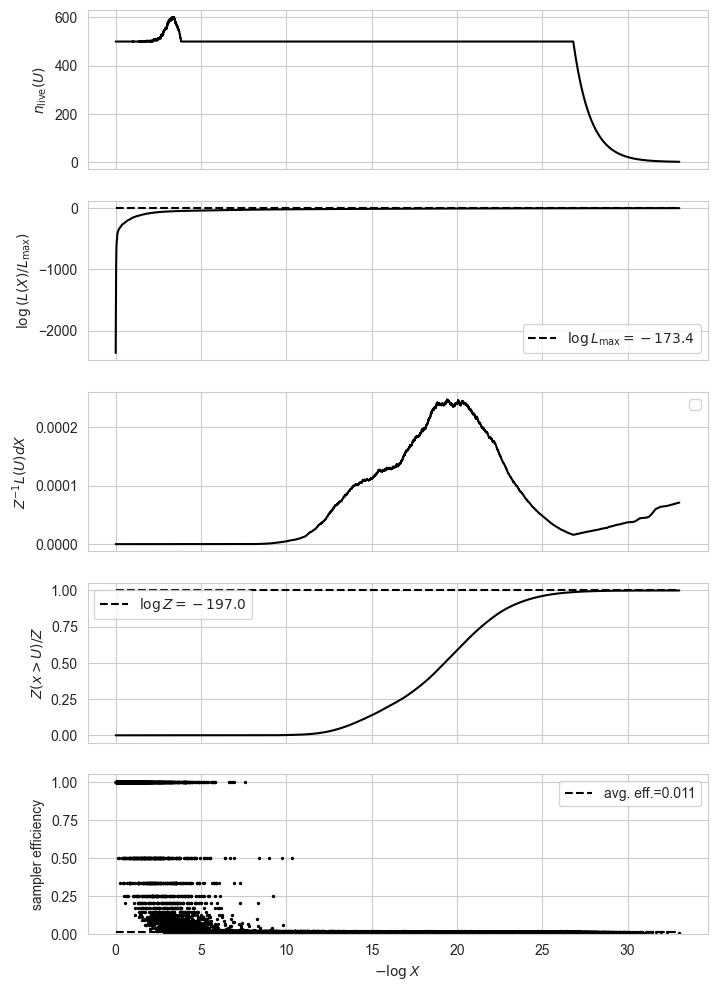

In [53]:
Exact_ns.plot_diagnostics(Results)

WARNING[2023-08-18 22:42:15,236]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


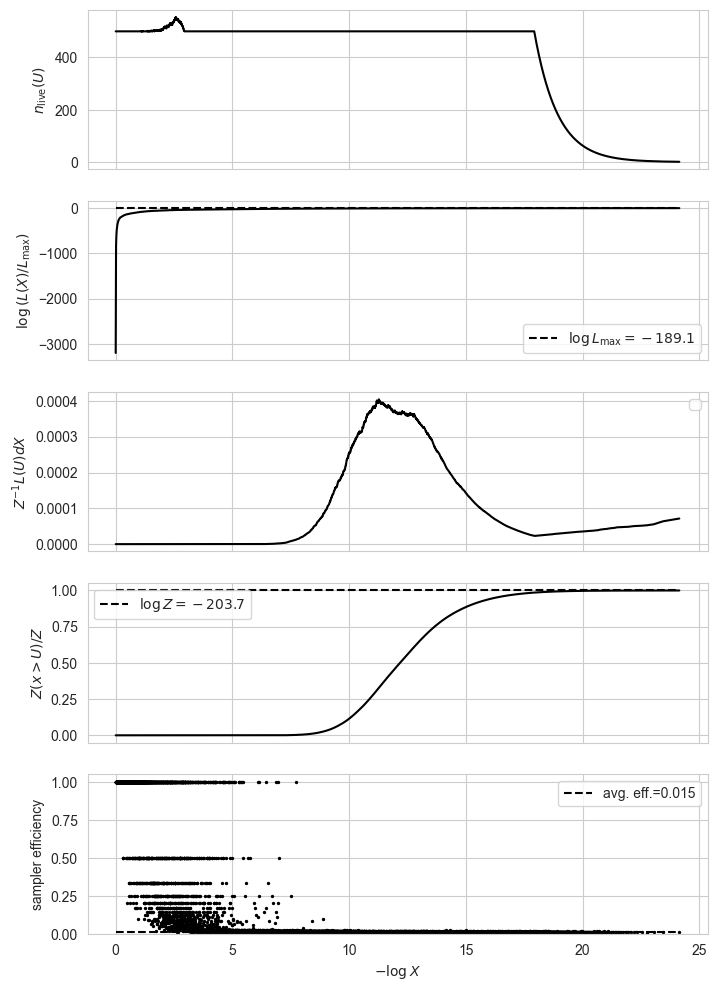

In [47]:
gpresult3.plot_diagnostics()

WARNING[2023-08-18 22:41:59,658]: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


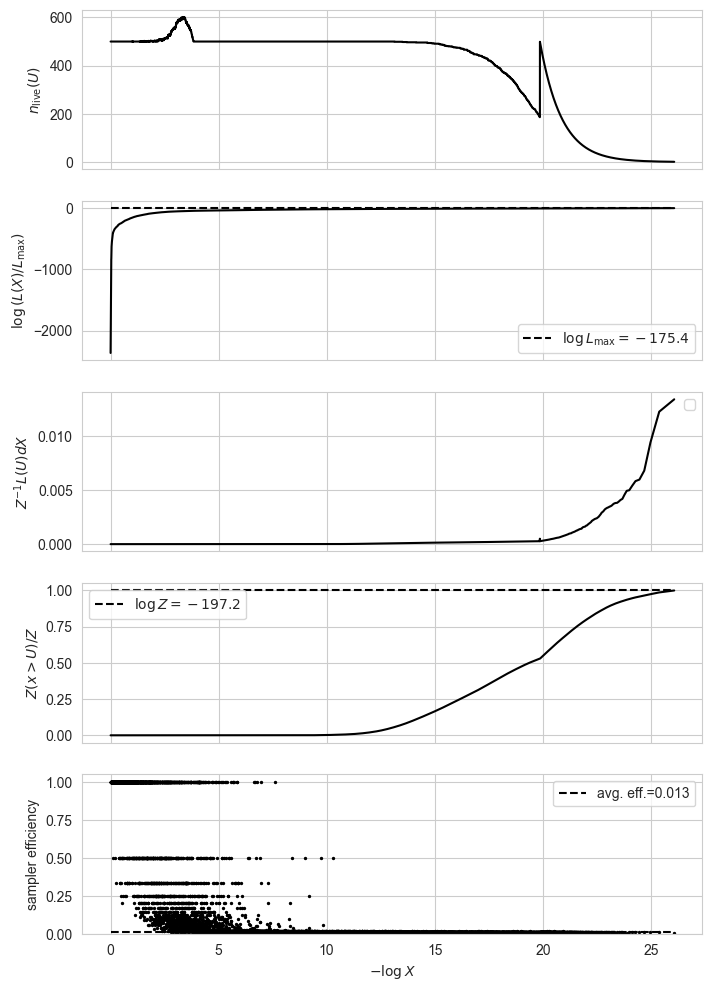

In [46]:
gpresult4.plot_diagnostics()

In [41]:
gpresult4.print_summary()

--------
Termination Conditions:
Reached max samples
--------
# likelihood evals: 789236
# samples: 10000
# slices: 247500.0
# slices / acceptance: 33.0
# likelihood evals / sample: 78.9
# likelihood evals / slice: 3.1
--------
logZ=-197.17 +- 0.18
H=200.0
ESS=352
--------
log_A[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_A[0]: 0.69 +- 0.36 | 0.1 / 0.76 / 1.06 | 0.8 | 0.8
log_A[1]: 0.78 +- 0.35 | 0.38 / 0.82 / 1.14 | 1.1 | 1.1
--------
log_aqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_aqpo: 0.26 +- 0.55 | -0.28 / 0.09 / 1.08 | 0.27 | 0.27
--------
log_arn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_arn: -0.14 +- 0.27 | -0.35 / -0.22 / 0.18 | -0.34 | -0.34
--------
log_cqpo: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
log_cqpo: -0.67 +- 0.71 | -1.62 / -0.66 / 0.22 | -0.56 | -0.56
--------
log_crn: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
lo

[]

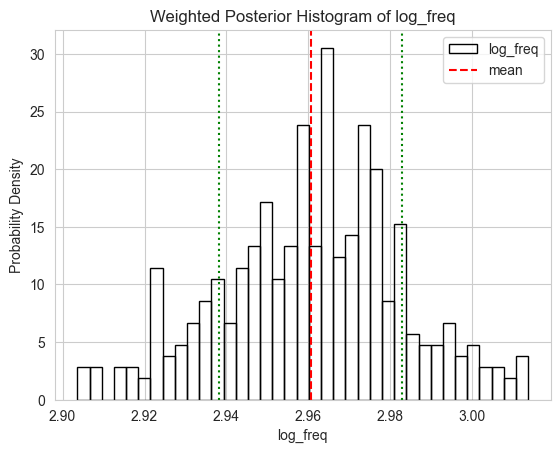

In [44]:
plot = gpresult4.weighted_posterior_plot("log_freq")
plt.plot()

## TO DO

1) investigate gpresult4 ess, and priors
2) See methods to ensure termination condition is met (small remaining evidence)